k fold 교차검증 orbit

# Import

In [1716]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
import pickle

import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from haversine import haversine
from IPython.display import HTML
import plotly.graph_objects as go
import copy 

import tqdm
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector 

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc

In [2]:
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from pyod.models.ocsvm import OCSVM
from pyod.models.mcd import MCD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.sos import SOS
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.lscp import LSCP

2024-06-29 16:36:55.792312: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 16:36:55.793888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 16:36:55.825858: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 16:36:55.826690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 16:36:56.433776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Class

In [3]:
class Conf_matrx:
    def __init__(self,original,compare):
        self.original = original
        self.compare = compare
    def conf(self,name):
        self.name = name
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        # fig, ax = plt.subplots(figsize=(5, 5))
        # ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        # for i in range(self.conf_matrix.shape[0]):
        #     for j in range(self.conf_matrix.shape[1]):
        #         ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        # plt.xlabel('Predictions', fontsize=18)
        # plt.ylabel('Actuals', fontsize=18)
        # plt.title('Confusion Matrix of ' + str(name), fontsize=18)
        # plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        # print('Accuracy: %.3f' % self.acc)
        # print('Precision: %.3f' % self.pre)
        # print('Recall: %.3f' % self.rec)
        # print('F1 Score: %.3f' % self.f1)

In [4]:
class Linear:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=20): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [5]:
class Orbit:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)

In [6]:
class BUNNY:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)

In [2247]:
class fortable:
    def __init__(self, df, clf, tab, outlier_true, conf_name = "Method"):
        self.df = df
        self.clf = clf
        self.conf_name = conf_name
        self.tabb = tab
        self.outlier_true = outlier_true
        
    def _forfit(self):
        if 'fnoise' in self.df.columns:
            self.clf.fit(self.df[['x', 'y','fnoise']])
        elif 'f' in self.df.columns:
            self.clf.fit(self.df[['x', 'y', 'f']])
        if 'f' not in self.df.columns:
            self.clf.fit(self.df[['x', 'y']])

    def _forlabels(self):
        self.labels = list(self.clf.labels_)

    def _forpredict(self):
        self.predict = self.clf.fit_predict(self.df)
        
    def comparison(self, compare_outlier = None, conf_outlier = None, gode = False):
        if gode == False:
            self._forfit()
            self._forlabels()
            if 'fnoise' in self.df.columns:
                compare_outlier = self.clf.decision_function(np.array(self.df[['x', 'y','fnoise']]))
            else:
                compare_outlier = self.clf.decision_function(self.df)
            if self.conf_name == "LOF":
                self._forpredict()
                conf_outlier = self.predict
            elif self.conf_name != "LOF":
                conf_outlier = self.labels
        elif gode == True:
            compare_outlier = compare_outlier
            conf_outlier = conf_outlier

        fpr, tpr, thresh = roc_curve(self.outlier_true, compare_outlier)       
        
        _conf = Conf_matrx(self.outlier_true, conf_outlier)
        _conf.conf(self.conf_name)
        
        _table = pd.concat([self.tabb,
                   pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)],"N":n, "Contamination": eta_sparsity},index = [_conf.name])])
        
        return _table

In [2248]:
class fortable:
    def __init__(self, df, clf, tab, outlier_true, conf_name = "Method"):
        self.df = df
        self.clf = clf
        self.conf_name = conf_name
        self.tabb = tab
        self.outlier_true = outlier_true
        
    def _forfit(self):
        if 'fnoise' in self.df.columns:
            self.clf.fit(self.df[['x', 'y','fnoise']])
        elif 'f' in self.df.columns:
            self.clf.fit(self.df[['x', 'y', 'f']])
        if 'f' not in self.df.columns:
            self.clf.fit(self.df[['x', 'y']])

    def _forlabels(self):
        self.labels = list(self.clf.labels_)

    def _forpredict(self):
        self.predict = self.clf.fit_predict(self.df)
        
    def comparison(self, compare_outlier = None, conf_outlier = None, gode = False):
        if gode == False:
            self._forfit()
            self._forlabels()
            if 'fnoise' in self.df.columns:
                compare_outlier = self.clf.decision_function(np.array(self.df[['x', 'y','fnoise']]))
            else:
                compare_outlier = self.clf.decision_function(self.df)
            if self.conf_name == "LOF":
                self._forpredict()
                conf_outlier = self.predict
            elif self.conf_name != "LOF":
                conf_outlier = self.labels
        elif gode == True:
            compare_outlier = compare_outlier
            conf_outlier = conf_outlier

        fpr, tpr, thresh = roc_curve(self.outlier_true, compare_outlier)       
        
        _conf = Conf_matrx(self.outlier_true, conf_outlier)
        _conf.conf(self.conf_name)
        
        _table = pd.concat([self.tabb,
                   pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)],"N":n, "Contamination": eta_sparsity,"kappa":kappa},index = [_conf.name])])
        
        return _table

# Linear

In [1210]:
# tab_linear = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])

In [1699]:
n = 10000
eta_sparsity = 0.2
random_seed = 77

In [1700]:
np.random.seed(6)

epsilon = np.around(np.random.normal(size=n),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, round(n*eta_sparsity/2)).round(15), np.random.uniform(5, 7, round(n*eta_sparsity/2)).round(15), np.repeat(0, n - round(n*eta_sparsity)))), n)
eta = signal + epsilon

outlier_true_linear= signal.copy()
outlier_true_linear = list(map(lambda x: 1 if x!=0 else 0,outlier_true_linear))

x_1 = np.linspace(0,2,n)
y1_1 = 5 * x_1
y_1 = y1_1 + eta # eta = signal + epsilon

_df=pd.DataFrame({'x':x_1, 'y':y_1})

w=np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

index_of_trueoutlier_bool = signal!=0

## GODE_Linear

In [1701]:
_Linear = Linear(_df)
_Linear.fit(sd=20)

outlier_GODE_linear_old = (_Linear.df['Residual']**2).tolist()
sorted_data = sorted(outlier_GODE_linear_old,reverse=True)
index = int(len(sorted_data) * eta_sparsity)
five_percent = sorted_data[index]
outlier_GODE_linear = list(map(lambda x: 1 if x > five_percent else 0,outlier_GODE_linear_old))

tab_lin = fortable(_df, clf = None, tab =tab_linear, outlier_true=outlier_true_linear, conf_name ="GODE")

tab_linear = tab_lin.comparison(compare_outlier = outlier_GODE_linear_old, conf_outlier = outlier_GODE_linear, gode = True)

## LOF_Linear

In [1702]:
np.random.seed(random_seed)
clf = LOF(contamination=eta_sparsity)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "LOF")

tab_linear = tab_lin.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


## KNN_Linear

In [1703]:
np.random.seed(random_seed)
clf = KNN(contamination=eta_sparsity)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "KNN")

tab_linear = tab_lin.comparison()

## CBLOF_Linear

In [1704]:
clf = CBLOF(contamination=eta_sparsity,random_state=random_seed)
tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "CBLOF")

tab_linear = tab_lin.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## OCSVM_Linear

In [1705]:
np.random.seed(random_seed)
clf = OCSVM(nu=eta_sparsity)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "OCSVM")

tab_linear = tab_lin.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


## MCD_Linear

In [1706]:
clf = MCD(contamination=eta_sparsity, random_state = random_seed)
tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "MCD")

tab_linear = tab_lin.comparison()

## Feature Bagging_Linear

In [1707]:
clf = FeatureBagging(contamination=eta_sparsity, random_state=random_seed)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "Feature Bagging")

tab_linear = tab_lin.comparison()

## ABOD_Linear

In [1708]:
np.random.seed(random_seed)
clf = ABOD(contamination=eta_sparsity)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "ABOD")

tab_linear = tab_lin.comparison()

## IForest_Linear

In [1709]:
clf = IForest(contamination=eta_sparsity, random_state=random_seed)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "Isolation Forest")

tab_linear = tab_lin.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


## HBOS_Linear

In [1710]:
np.random.seed(random_seed)
clf = HBOS(contamination=eta_sparsity)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "HBOS")

tab_linear = tab_lin.comparison()

## SOS_Linear

In [1711]:
np.random.seed(random_seed)
clf = SOS(contamination=eta_sparsity)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "SOS")

tab_linear = tab_lin.comparison()

## LSCP_Linear

In [1712]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=eta_sparsity, random_state=random_seed)

tab_lin = fortable(_df, clf, tab_linear, outlier_true_linear, "LSCP")

tab_linear = tab_lin.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


## tab_linear

In [1713]:
round(tab_linear,3)#.to_csv('./Example_1_2.csv')

,Accuracy,Precision,Recall,F1,AUC,N,Contamination
GODE,0.999,1.000,0.980,0.990,1.000,1000.0,0.05
LOF,0.991,0.920,0.902,0.911,0.998,1000.0,0.05
KNN,0.991,0.920,0.902,0.911,0.997,1000.0,0.05
CBLOF,0.969,0.700,0.686,0.693,0.959,1000.0,0.05
OCSVM,0.923,0.370,0.725,0.490,0.864,1000.0,0.05
...,...,...,...,...,...,...,...
ABOD,0.898,0.740,0.746,0.743,0.927,10000.0,0.20
Isolation Forest,0.954,0.882,0.889,0.885,0.988,10000.0,0.20
HBOS,0.881,0.738,0.619,0.673,0.801,10000.0,0.20
SOS,0.684,0.207,0.209,0.208,0.501,10000.0,0.20


In [1715]:
# tab_linear.to_csv('./Example_1_Dataset.csv')

# Orbit

In [2128]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])

In [1719]:
n = 1000
eta_sparsity = 0.05
random_seed=77

In [2129]:
n_values = list(range(1000, 11000, 1000))  
eta_sparsity_list = list([0.01,0.05,0.1,0.2])
random_seed=77
# tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC","N","Contamination"])

In [1720]:
np.random.seed(777)
epsilon = np.around(np.random.normal(size=n),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
eta = signal + epsilon
pi=np.pi
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + eta
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})
outlier_true_orbit = signal.copy()
outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))

## GODE_Orbit

In [1721]:
_Orbit = Orbit(_df)
_Orbit.get_distance()

_Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=2500) 
_Orbit.fit(sd=15)

outlier_GODE_orbit_old = (_Orbit.df['Residual']**2).tolist()
sorted_data = sorted(outlier_GODE_orbit_old,reverse=True)
index = int(len(sorted_data) * eta_sparsity)
five_percent = sorted_data[index]
outlier_GODE_orbit = list(map(lambda x: 1 if x > five_percent else 0,outlier_GODE_orbit_old))

tab_orb = fortable(_df, clf = None, tab =tab_orbit, outlier_true=outlier_true_orbit, conf_name ="GODE")

tab_orbit = tab_orb.comparison(compare_outlier = outlier_GODE_orbit_old, conf_outlier = outlier_GODE_orbit, gode = True)

100%|██████████| 1000/1000 [00:01<00:00, 761.17it/s]
/tmp/ipykernel_787565/2517866040.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,


In [ ]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC","N","Contamination","kappa"])

kappa_values = list(range(10, 110, 10))
n_values = list(range(1000, 11000, 1000))  
eta_sparsity_list = list([0.01,0.05,0.1,0.2])
    
for eta_sparsity in eta_sparsity_list:
    
    for n in n_values:

        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
    
        _df_orbit = _df[['x','y','f']]


        for kappa in kappa_values:
            _Orbit = Orbit(_df_orbit)
            _Orbit.get_distance()
            
            _Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=kappa) 
            _Orbit.fit(sd=15)
            
            outlier_GODE_orbit_old = (_Orbit.df['Residual']**2).tolist()
            sorted_data = sorted(outlier_GODE_orbit_old,reverse=True)
            index = int(len(sorted_data) * eta_sparsity)
            percent = sorted_data[index]
            outlier_GODE_orbit = list(map(lambda x: 1 if x > percent else 0,outlier_GODE_orbit_old))
            
            tab_orb = fortable(_df_orbit, clf = None, tab =tab_orbit, outlier_true=outlier_true_orbit, conf_name ="GODE")
            
            tab_orbit = tab_orb.comparison(compare_outlier = outlier_GODE_orbit_old, conf_outlier = outlier_GODE_orbit, gode = True)

100%|██████████| 1000/1000 [00:01<00:00, 737.48it/s]
/tmp/ipykernel_787565/1145116151.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,
 72%|███████▏  | 7204/10000 [01:59<00:20, 133.31it/s]

In [2311]:
tab_orbit

,Accuracy,Precision,Recall,F1,AUC,N,Contamination,kappa
GODE,0.9870,0.200,0.285714,0.235294,0.849230,1000,0.01,10
GODE,0.9910,0.400,0.571429,0.470588,0.962308,1000,0.01,20
GODE,0.9910,0.400,0.571429,0.470588,0.962308,1000,0.01,30
GODE,0.9910,0.400,0.571429,0.470588,0.962308,1000,0.01,40
GODE,0.9910,0.400,0.571429,0.470588,0.962308,1000,0.01,50
...,...,...,...,...,...,...,...,...
GODE,0.8794,0.696,0.699497,0.697744,0.884629,10000,0.20,60
GODE,0.8794,0.696,0.699497,0.697744,0.884629,10000,0.20,70
GODE,0.8794,0.696,0.699497,0.697744,0.884629,10000,0.20,80
GODE,0.8794,0.696,0.699497,0.697744,0.884629,10000,0.20,90


In [2356]:
tab_orbit.groupby(['N', 'Contamination'])['AUC'].max()

N      Contamination
1000   0.01             0.962308
       0.05             0.893023
       0.10             0.865804
       0.20             0.864762
2000   0.01             0.826659
       0.05             0.888375
       0.10             0.913152
       0.20             0.880362
3000   0.01             0.884445
       0.05             0.925609
       0.10             0.847302
       0.20             0.866105
4000   0.01             0.949126
       0.05             0.858195
       0.10             0.896245
       0.20             0.885540
5000   0.01             0.871075
       0.05             0.888493
       0.10             0.863432
       0.20             0.881710
6000   0.01             0.919313
       0.05             0.889034
       0.10             0.883946
       0.20             0.876822
7000   0.01             0.884302
       0.05             0.882739
       0.10             0.877925
       0.20             0.883766
8000   0.01             0.921041
       0.05           

In [2322]:
tab_orbit.loc[tab_orbit.groupby(['N', 'Contamination'])['AUC'].idxmax(),:]

,Accuracy,Precision,Recall,F1,AUC,N,Contamination,kappa
GODE,0.9870,0.200,0.285714,0.235294,0.849230,1000,0.01,10
GODE,0.9910,0.400,0.571429,0.470588,0.962308,1000,0.01,20
GODE,0.9910,0.400,0.571429,0.470588,0.962308,1000,0.01,30
GODE,0.9910,0.400,0.571429,0.470588,0.962308,1000,0.01,40
GODE,0.9910,0.400,0.571429,0.470588,0.962308,1000,0.01,50
...,...,...,...,...,...,...,...,...
GODE,0.8794,0.696,0.699497,0.697744,0.884629,10000,0.20,60
GODE,0.8794,0.696,0.699497,0.697744,0.884629,10000,0.20,70
GODE,0.8794,0.696,0.699497,0.697744,0.884629,10000,0.20,80
GODE,0.8794,0.696,0.699497,0.697744,0.884629,10000,0.20,90


In [2319]:
pd.merge(tab_orbit.groupby(['N', 'Contamination']).max('AUC').reset_index(),tab_orbit,how='left')

,N,Contamination,Accuracy,Precision,Recall,F1,AUC,kappa
0,1000,0.01,0.9910,0.400,0.571429,0.470588,0.962308,20
1,1000,0.01,0.9910,0.400,0.571429,0.470588,0.962308,30
2,1000,0.01,0.9910,0.400,0.571429,0.470588,0.962308,40
3,1000,0.01,0.9910,0.400,0.571429,0.470588,0.962308,50
4,1000,0.01,0.9910,0.400,0.571429,0.470588,0.962308,60
...,...,...,...,...,...,...,...,...
355,10000,0.20,0.8794,0.696,0.699497,0.697744,0.884629,60
356,10000,0.20,0.8794,0.696,0.699497,0.697744,0.884629,70
357,10000,0.20,0.8794,0.696,0.699497,0.697744,0.884629,80
358,10000,0.20,0.8794,0.696,0.699497,0.697744,0.884629,90


In [2280]:
import seaborn as sns

/tmp/ipykernel_787565/2646201208.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.heatmap(tab_orb.tabb['AUC'][i].reshape(1, -1), annot=True, cmap='viridis', fmt='.2f',
/tmp/ipykernel_787565/2646201208.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.heatmap(tab_orb.tabb['AUC'][i].reshape(1, -1), annot=True, cmap='viridis', fmt='.2f',
/tmp/ipykernel_787565/2646201208.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s

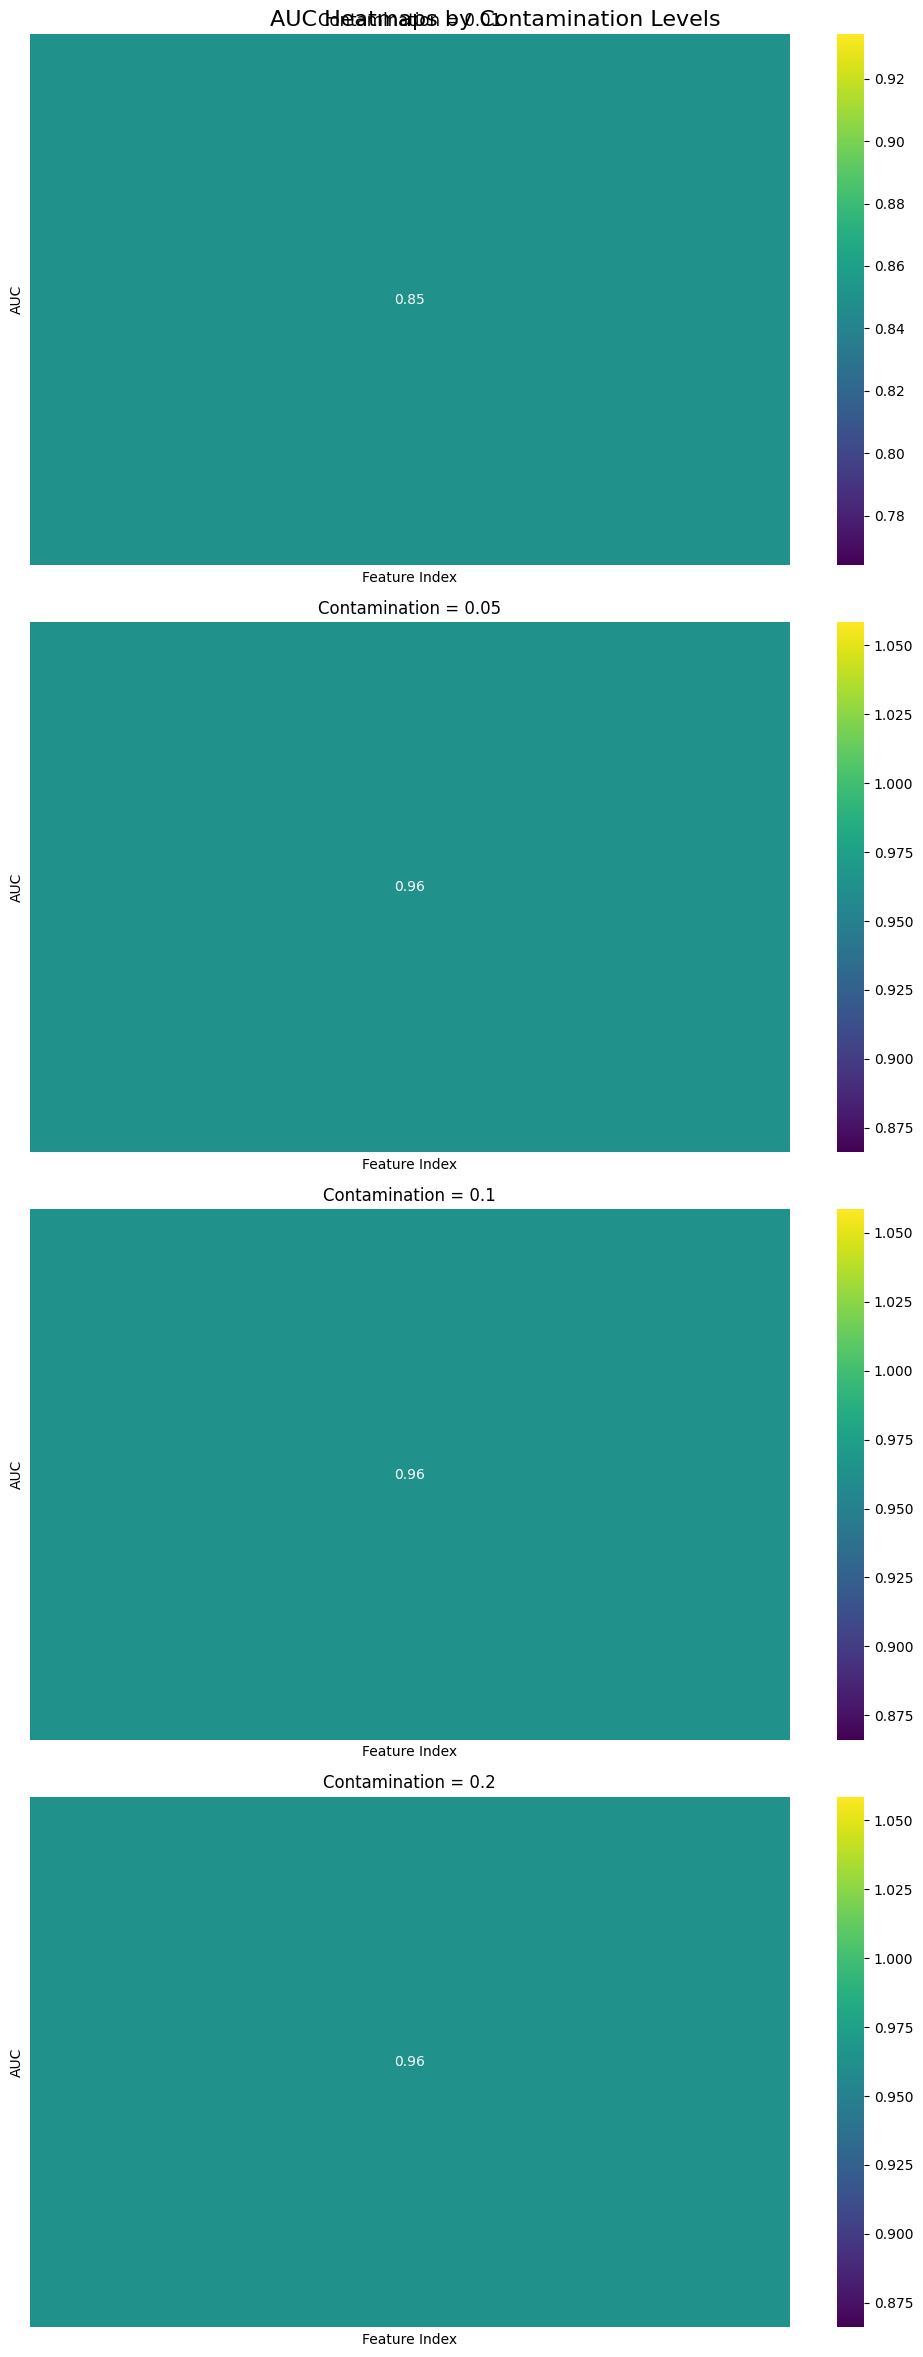

In [2284]:
fig, axs = plt.subplots(len(eta_sparsity_list), 1, figsize=(10, 6 * len(eta_sparsity_list)), sharex=True)

for i, contamination in enumerate(eta_sparsity_list):
    sns.heatmap(tab_orb.tabb['AUC'][i].reshape(1, -1), annot=True, cmap='viridis', fmt='.2f',
                xticklabels=False, yticklabels=False, cbar=True, ax=axs[i])
    axs[i].set_title(f'Contamination = {contamination}')
    axs[i].set_ylabel('AUC')
    axs[i].set_xlabel('Feature Index')

# 전체 그래프의 제목 설정
fig.suptitle('AUC Heatmaps by Contamination Levels', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
_Orbit = Orbit(_df)
_Orbit.get_distance()

_Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=2500) 
_Orbit.fit(sd=15)

outlier_GODE_orbit_old = (_Orbit.df['Residual']**2).tolist()
sorted_data = sorted(outlier_GODE_orbit_old,reverse=True)
index = int(len(sorted_data) * eta_sparsity)
five_percent = sorted_data[index]
outlier_GODE_orbit = list(map(lambda x: 1 if x > five_percent else 0,outlier_GODE_orbit_old))

tab_orb = fortable(_df, clf = None, tab =tab_orbit, outlier_true=outlier_true_orbit, conf_name ="GODE")

tab_orbit = tab_orb.comparison(compare_outlier = outlier_GODE_orbit_old, conf_outlier = outlier_GODE_orbit, gode = True)

## LOF_Orbit

In [2127]:
np.random.seed(random_seed)
clf = LOF(contamination=eta_sparsity)

tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "LOF")

tab_orbit = tab_orb.comparison()

In [2130]:
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        np.random.seed(random_seed)
        clf = LOF(contamination=eta_sparsity)
        
        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "LOF")
        
        tab_orbit = tab_orb.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/u

In [2132]:
tab_orbit_LOF = tab_orbit

## KNN_Orbit

In [ ]:
np.random.seed(random_seed)
clf = KNN(contamination=eta_sparsity)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "kNN")

tab_orbit = tab_orb.comparison()

In [2133]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        np.random.seed(random_seed)
        clf = KNN(contamination=eta_sparsity)
        
        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "kNN")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_kNN = tab_orbit

/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,


## CBLOF_Orbit

In [1724]:
clf = CBLOF(contamination=eta_sparsity,random_state=random_seed)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "CBLOF")

tab_orbit = tab_orb.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2136]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        clf = CBLOF(contamination=eta_sparsity,random_state=random_seed)

        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "CBLOF")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_CBLOF = tab_orbit

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/csy/anaconda3/envs/pygsp/lib/python3.10/sit

## OCSVM_Orbit

In [1725]:
np.random.seed(random_seed)
clf = OCSVM(nu=eta_sparsity)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "OCSVM")

tab_orbit = tab_orb.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


In [2138]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        np.random.seed(random_seed)
        clf = OCSVM(nu=eta_sparsity)
        
        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "OCSVM")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_OCSVM = tab_orbit

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarni

## MCD_Orbit

In [1726]:
clf = MCD(contamination=eta_sparsity , random_state = random_seed)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "MCD")

tab_orbit = tab_orb.comparison()

In [2140]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        clf = MCD(contamination=eta_sparsity , random_state = random_seed)

        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "MCD")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_MCD = tab_orbit

/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,


## Feature Bagging_Orbit

In [1727]:
clf = FeatureBagging(contamination=eta_sparsity, random_state=random_seed)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "Feature Bagging")

tab_orbit = tab_orb.comparison()

In [2143]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        clf = FeatureBagging(contamination=eta_sparsity, random_state=random_seed)

        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "Feature Bagging")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_Feature = tab_orbit

/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,


## ABOD_Orbit

In [1728]:
np.random.seed(random_seed)
clf = ABOD(contamination=eta_sparsity)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "ABOD")

tab_orbit = tab_orb.comparison()

In [2145]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        np.random.seed(random_seed)
        clf = ABOD(contamination=eta_sparsity)
        
        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "ABOD")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_ABOD = tab_orbit

/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,


## IForest_Orbit

In [1729]:
clf = IForest(contamination=eta_sparsity,random_state=random_seed)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "Isolation Forest")

tab_orbit = tab_orb.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [2147]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        clf = IForest(contamination=eta_sparsity,random_state=random_seed)

        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "Isolation Forest")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_Isolation = tab_orbit

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:45

## HBOS_Orbit

In [1730]:
np.random.seed(random_seed)
clf = HBOS(contamination=eta_sparsity)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "HBOS")

tab_orbit = tab_orb.comparison()

In [2150]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        np.random.seed(random_seed)
        clf = HBOS(contamination=eta_sparsity)
        
        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "HBOS")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_HBOS = tab_orbit

/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,


## SOS_Orbit

In [1731]:
np.random.seed(random_seed)
clf = SOS(contamination=eta_sparsity)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "SOS")

tab_orbit = tab_orb.comparison()

In [2152]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        np.random.seed(random_seed)
        clf = SOS(contamination=eta_sparsity)
        
        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "SOS")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_SOS = tab_orbit

/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,


## LSCP_Orbit

In [1732]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=eta_sparsity, random_state=random_seed)

tab_orb = fortable(_df, clf, tab_orbit, outlier_true_orbit, "LSCP")

tab_orbit = tab_orb.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


In [ ]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
for n in n_values:
    for eta_sparsity in eta_sparsity_list:
        np.random.seed(777)
        epsilon = np.around(np.random.normal(size=n),15)
        signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, round(n * eta_sparsity / 2)).round(15), np.random.uniform(1, 4, round(n * eta_sparsity / 2)).round(15), np.repeat(0, n - round(n * eta_sparsity)))), n)
        eta = signal + epsilon
        pi=np.pi
        ang=np.linspace(-pi,pi-2*pi/n,n)
        r=5+np.cos(np.linspace(0,12*pi,n))
        vx=r*np.cos(ang)
        vy=r*np.sin(ang)
        f1=10*np.sin(np.linspace(0,6*pi,n))
        f = f1 + eta
        _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})
        outlier_true_orbit = signal.copy()
        outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))
        index_of_trueoutlier_bool = signal!=0
            
        detectors = [KNN(), LOF(), OCSVM()]
        clf = LSCP(detectors,contamination=eta_sparsity, random_state=random_seed)
        
        tab_orb = fortable(_df[['x','y','f']], clf, tab_orbit, outlier_true_orbit, "LSCP")
        
        tab_orbit = tab_orb.comparison()
tab_orbit_LSCP = tab_orbit

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(
/tmp/ipykernel_787565/3780776973.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  _table = pd.concat([self.tabb,
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.

In [ ]:
tab_orbit_LSCP

## tab_orbit

In [1733]:
round(tab_orbit,3)

,Accuracy,Precision,Recall,F1,AUC,N,Contamination
GODE,0.961,0.600,0.612,0.606,0.893,1000.0,0.05
LOF,0.921,0.200,0.204,0.202,0.664,1000.0,0.05
kNN,0.947,0.460,0.469,0.465,0.848,1000.0,0.05
CBLOF,0.911,0.100,0.102,0.101,0.533,1000.0,0.05
OCSVM,0.893,0.210,0.429,0.282,0.789,1000.0,0.05
MCD,0.911,0.100,0.102,0.101,0.454,1000.0,0.05
Feature Bagging,0.921,0.200,0.204,0.202,0.678,1000.0,0.05
ABOD,0.951,0.500,0.510,0.505,0.864,1000.0,0.05
Isolation Forest,0.925,0.240,0.245,0.242,0.618,1000.0,0.05
HBOS,0.921,0.105,0.082,0.092,0.530,1000.0,0.05


In [2168]:
# pd.concat([tab_orbit_LOF,
#            tab_orbit_kNN,
#           tab_orbit_CBLOF,
#           tab_orbit_OCSVM,
#           tab_orbit_MCD,
#           tab_orbit_Feature,
#           tab_orbit_ABOD,
#           tab_orbit_Isolation,
#           tab_orbit_HBOS,
#           tab_orbit_SOS,
#           tab_orbit_LSCP]).to_csv('./Example_2_Other_Dataset.csv')

# Bunny

In [2046]:
# tab_bunny = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])

In [2095]:
eta_sparsity = 0.2
random_seed=77
n = 2503

In [2096]:
with open("../../2_research/Bunny.pkl", "rb") as file:
    loaded_obj = pickle.load(file)

In [2097]:
_df = pd.DataFrame({'x':loaded_obj['x'],'y':loaded_obj['y'],'z':loaded_obj['z'],'fnoise':loaded_obj['f']+loaded_obj['noise'],'f':loaded_obj['f'],'noise':loaded_obj['noise']})
outlier_true_bunny = loaded_obj['unif'].copy()
outlier_true_bunny = list(map(lambda x: 1 if x !=0  else 0,outlier_true_bunny))
index_of_trueoutlier_bool_bunny = loaded_obj['unif']!=0
_W = loaded_obj['W'].copy()

## GODE_Bunny

In [2098]:
_BUNNY = BUNNY(_df)
_BUNNY.fit(sd=20)

outlier_GODE_bunny_old = (_BUNNY.df['Residual']**2).tolist()
sorted_data = sorted(outlier_GODE_bunny_old,reverse=True)
index = int(len(sorted_data) * eta_sparsity)
n_percent = sorted_data[index]
outlier_GODE_bunny = list(map(lambda x: 1 if x > n_percent else 0,outlier_GODE_bunny_old))

tab_bun = fortable(_df, clf = None, tab =tab_bunny, outlier_true=outlier_true_bunny, conf_name ="GODE")

tab_bunny = tab_bun.comparison(compare_outlier = outlier_GODE_bunny_old, conf_outlier = outlier_GODE_bunny, gode = True)

## LOF_Bunny

In [2099]:
np.random.seed(random_seed)
clf = LOF(contamination=eta_sparsity)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "LOF")

tab_bunny = tab_bun.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


## KNN_Bunny

In [2100]:
np.random.seed(random_seed)
clf = KNN(contamination=eta_sparsity)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "kNN")

tab_bunny = tab_bun.comparison()

## CBLOF_Bunny

In [2101]:
clf = CBLOF(contamination=eta_sparsity,random_state=random_seed)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "CBLOF")

tab_bunny = tab_bun.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## OCSVM_Bunny

In [2102]:
np.random.seed(random_seed)
clf = OCSVM(nu=eta_sparsity)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "OCSVM")

tab_bunny = tab_bun.comparison()

## MCD_Bunny

In [2103]:
clf = MCD(contamination=eta_sparsity , random_state = random_seed)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "MCD")

tab_bunny = tab_bun.comparison()

## Feature Bagging_Bunny

In [2104]:
clf = FeatureBagging(contamination=eta_sparsity, random_state=random_seed)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "Feature Bagging")

tab_bunny = tab_bun.comparison()

## ABOD_Bunny

In [2105]:
np.random.seed(random_seed)
clf = ABOD(contamination=eta_sparsity)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "ABOD")

tab_bunny = tab_bun.comparison()

## IForest_Bunny

In [2106]:
clf = IForest(contamination=eta_sparsity,random_state=random_seed)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "Isolation Forest")

tab_bunny = tab_bun.comparison()

## HBOS_Bunny

In [2107]:
np.random.seed(random_seed)
clf = HBOS(contamination=eta_sparsity)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "HBOS")

tab_bunny = tab_bun.comparison()

## SOS_Bunny

In [2108]:
np.random.seed(random_seed)
clf = SOS(contamination=eta_sparsity)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "SOS")

tab_bunny = tab_bun.comparison()

## LSCP_Bunny

In [2109]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=eta_sparsity, random_state=random_seed)

tab_bun = fortable(_df, clf, tab_bunny, outlier_true_bunny, "LSCP")

tab_bunny = tab_bun.comparison()

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


## tab_bunny

In [2110]:
round(tab_bunny,3)

,Accuracy,Precision,Recall,F1,AUC,N,Contamination
GODE,0.962,1.000,0.208,0.345,0.994,2503.0,0.01
LOF,0.958,0.808,0.175,0.288,0.884,2503.0,0.01
kNN,0.962,1.000,0.217,0.356,0.979,2503.0,0.01
CBLOF,0.962,1.000,0.217,0.356,0.948,2503.0,0.01
OCSVM,0.888,0.179,0.375,0.243,0.736,2503.0,0.01
MCD,0.962,1.000,0.217,0.356,0.981,2503.0,0.01
Feature Bagging,0.958,0.808,0.175,0.288,0.889,2503.0,0.01
ABOD,0.962,0.962,0.208,0.342,0.967,2503.0,0.01
Isolation Forest,0.962,1.000,0.217,0.356,0.957,2503.0,0.01
HBOS,0.949,0.333,0.067,0.111,0.822,2503.0,0.01


In [2111]:
# tab_bunny.to_csv('./Example_3_Dataset.csv')